# Wildfire Prevention in Canada

## 1. Introduction

Wildfires are a critical natural disaster that pose significant threats to both human lives and natural ecosystems. In the vast landscape of Canada, where forests and grasslands cover a substantial portion of the country, wildfire prevention and management take on a paramount importance. Canada's unique geographical features and climate conditions make it particularly susceptible to wildfires that can spread rapidly and inflict extensive damage.

The significance of wildfire prevention in Canada cannot be overstated. As the frequency and intensity of wildfires have been observed to increase in recent years, with 2023 being another year with widespread destruction. Understanding and implementing effective prevention strategies are crucial to safeguarding communities, preserving wildlife habitats, and maintaining the overall environmental balance. In addition to the immediate risks they pose, wildfires contribute to air pollution, disrupt water supplies, and release significant amounts of carbon dioxide, exacerbating climate change effects.

In this context, technological advancements, data-driven insights, and predictive modeling play a vital role in enhancing wildfire prevention efforts. By harnessing the power of machine learning, remote sensing, and geographic information systems, stakeholders can better predict fire behavior, assess risk factors, and strategically allocate resources for early intervention and containment.

This project focuses on the development of AI tools and methodologies that contribute to effective wildfire prevention in Canada. The core investigation involves assessing the efficacy of machine learning techniques in predicting wildfire likelihood through the classification of satellite imagery. With advanced algorithms and data-driven insights, we could predict the location of potential wildfires, apply preventative steps and mitigate their impact.

## 2. The Data

Data from https://open.canada.ca/data/en/dataset/9d8f219c-4df0-4481-926f-8a2a532ca003

In [ ]:
"""
from struct import unpack
import os
import os.path as osp
    
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}
    
class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        
    
bads = []
i=0

for folder_name in ("wildfire","nowildfire"):
    folder_path = osp.join("valid",folder_name)
    for fname in os.listdir(folder_path):
        i += 1
        fpath = os.path.join(folder_path, fname)
        image = JPEG(fpath) 
        try:
            image.decode()   
        except:
            bads.append(fpath)

print(i)
print(bads)
#for name in bads:
#    os.remove(osp.join("train",name))
"""

In [165]:
#Import modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from PIL import Image
from tensorflow.keras.layers import Dense, Softmax, Flatten

In [147]:
img_size=128
batch_size=32

img_shape=(img_size,img_size)
train_ds=tf.keras.utils.image_dataset_from_directory(directory="train",
                                                     labels='inferred',
                                                     label_mode='int',
                                                     image_size=img_shape,
                                                     batch_size=batch_size)

valid_ds=tf.keras.utils.image_dataset_from_directory(directory="valid",
                                                     labels='inferred',
                                                     label_mode='int',
                                                     image_size=img_shape,
                                                     batch_size=batch_size)


                                                     


Found 30249 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.


In [11]:
print(train_ds.class_names)
print(valid_ds.class_names)
print(test_ds.class_names)

['nowildfire', 'wildfire']
['nowildfire', 'wildfire']
['nowildfire', 'wildfire']


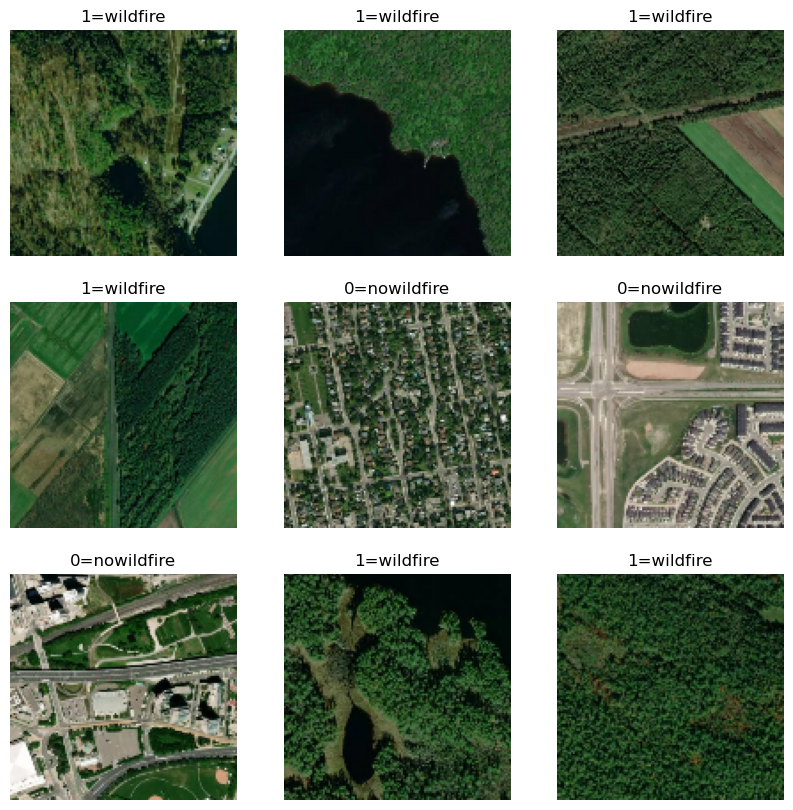

In [149]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy())+"="+train_ds.class_names[labels[i]])
        plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE 
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. MobileNetV2 Model

The MobileNetV2 Model was chosen as it is a smaller, faster network that can allow for faster itterating compared to others. Initial testing revealed that image_size=64 was too small, leading to poorer accuracy, while image_size larger than 128 saw only marginal improvements for a large training time cost. An image size of 128 caused larger networks (e.g. VGG19) to take far longer to train meaning slow itterative improvements to the model.

Various sized Dense layers were tested until the model both had high training accuracy, and trained quickly. Initially there was a variance issue which was resolved by including two Dropout layers for regularisation.

### Building the Model

In [24]:
def MobileNetV2_model(img_size):

    MNV2=tf.keras.applications.MobileNetV2(include_top=False, input_shape=(img_size,img_size,3),weights='imagenet')
    for layer in MNV2.layers:
        layer.trainable=False

    inputs=tf.keras.Input(shape=(img_size,img_size,3))
    X=tfl.Rescaling(1./255)(inputs)
    X=MNV2(X)
    X=Flatten()(X)
    X=tfl.Dropout(rate=0.5,input_shape=X.shape)(X)
    X=Dense(units=512,activation='relu')(X)
    X=tfl.Dropout(rate=0.5,input_shape=X.shape)(X)
    X=Dense(units=126,activation='relu')(X)
    outputs=Dense(units=2,activation='softmax')(X)
    return tf.keras.Model(inputs=inputs,outputs=outputs)
    

In [26]:
mnv2=MobileNetV2_model(img_size)
mnv2.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_6 (Dropout)         (None, 20480)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               10486272  
                                                           

In [27]:
mnv2.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

### Training the Model

about 5 minutes per epoch

In [28]:
history=mnv2.fit(train_ds,validation_data=valid_ds,epochs=10)

Epoch 1/10


c:\Users\HM191112\anaconda3\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


946/946 [==============================] - 270s 283ms/step - loss: 0.3218 - accuracy: 0.9116 - val_loss: 0.1668 - val_accuracy: 0.9483
Epoch 2/10
946/946 [==============================] - 301s 318ms/step - loss: 0.1695 - accuracy: 0.9382 - val_loss: 0.1390 - val_accuracy: 0.9549
Epoch 3/10
946/946 [==============================] - 279s 295ms/step - loss: 0.1463 - accuracy: 0.9464 - val_loss: 0.1429 - val_accuracy: 0.9498
Epoch 4/10
946/946 [==============================] - 281s 297ms/step - loss: 0.1317 - accuracy: 0.9530 - val_loss: 0.1163 - val_accuracy: 0.9613
Epoch 5/10
946/946 [==============================] - 271s 286ms/step - loss: 0.1213 - accuracy: 0.9557 - val_loss: 0.1054 - val_accuracy: 0.9616
Epoch 6/10
946/946 [==============================] - 272s 287ms/step - loss: 0.1099 - accuracy: 0.9587 - val_loss: 0.1108 - val_accuracy: 0.9598
Epoch 7/10
946/946 [==============================] - 271s 287ms/step - loss: 0.0991 - accuracy: 0.9638 - val_loss: 0.0965 - val_accura

In [19]:
#mnv2.save('saves/mobile_net.keras')

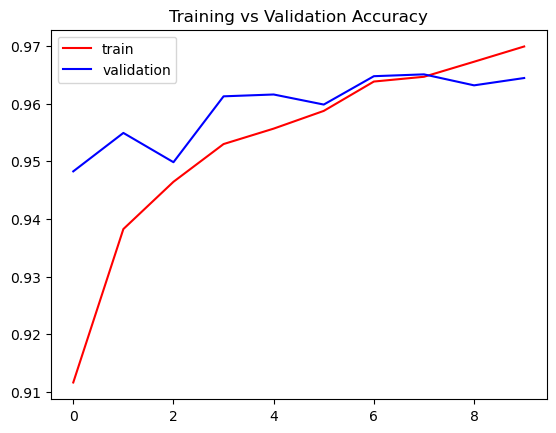

In [29]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

## Testing the Model

In [220]:
test_ds=tf.keras.utils.image_dataset_from_directory(directory="test",
                                                     labels='inferred',
                                                     label_mode='int',
                                                     image_size=img_shape,
                                                     batch_size=batch_size,
                                                     shuffle=False)





Found 6299 files belonging to 2 classes.


In [270]:
y_test=np.array([])
#predictions=np.array([])
for image, label in test_ds.map(lambda x, y: (x, y)):
    y_test=np.append(y_test, label)

y_test.flatten()

array([0., 0., 0., ..., 1., 1., 1.])

In [283]:
mnv2.evaluate(test_ds)

197/197 [==============================] - 42s 215ms/step - loss: 0.0875 - accuracy: 0.9703


[0.08745909482240677, 0.970312774181366]

In [271]:
predictions=np.argmax(mnv2.predict(test_ds),axis=1)

197/197 [==============================] - 44s 224ms/step


In [273]:
print(predictions)
print(y_test)

[0 0 0 ... 1 1 1]
[0. 0. 0. ... 1. 1. 1.]


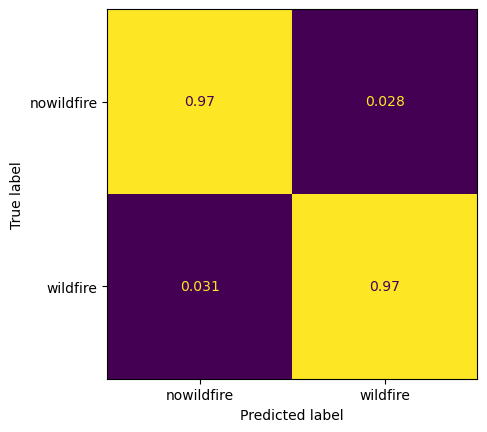

In [274]:

from sklearn.metrics import ConfusionMatrixDisplay

cf_display2=ConfusionMatrixDisplay.from_predictions(y_test,predictions,
    normalize='true',
    display_labels=test_ds.class_names,
    colorbar=False)



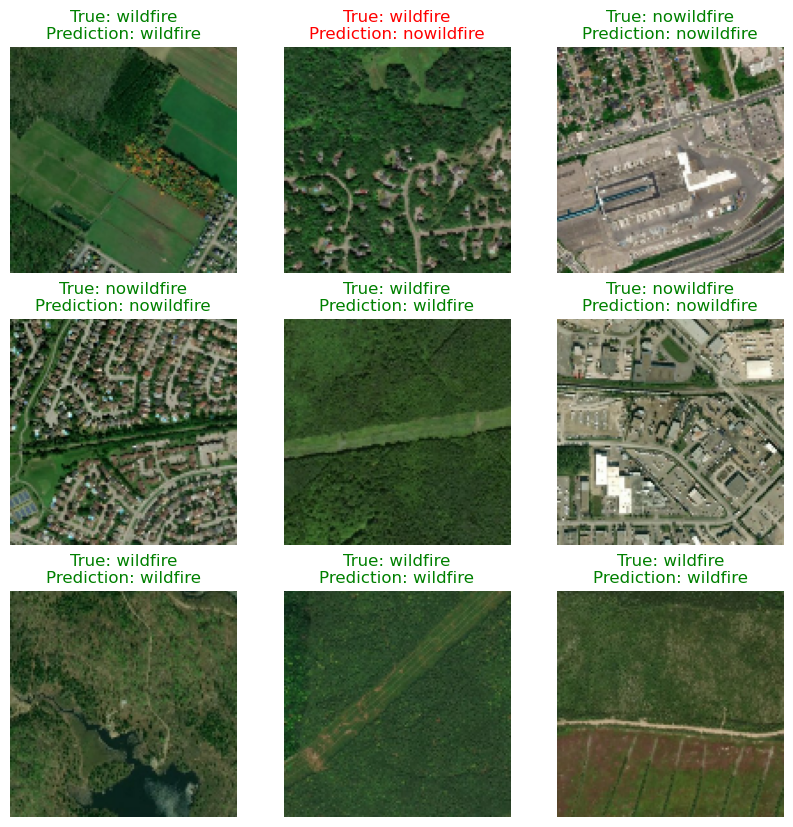

In [282]:
enum_test_ds=test_ds.unbatch()
enum_test_ds=enum_test_ds.enumerate()
enum_test_ds=enum_test_ds.shuffle(6299)

plt.figure(figsize=(10,10))
n=0
for j, (image,label) in enum_test_ds.take(9):
    ax = plt.subplot(3, 3, n + 1)
    n+=1
    plt.imshow(image.numpy().astype("uint8"))
    true=train_ds.class_names[label]
    prediction=train_ds.class_names[predictions[j]]
    if prediction==true:
        color = 'green'
    else:
        color = 'red'
    plt.title("True: "+true+"\nPrediction: "+prediction, color=color)
    plt.axis("off")


The MobileNetV2 Model shows a very high 97% accuracy on the test set.

## VGG19

In [32]:
def vgg19_model(img_size):
    inputs=tf.keras.Input(shape=(img_size,img_size,3))
    X=tfl.Rescaling(1./255)(inputs)
    vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet',classifier_activation='softmax')
    for layer in vgg.layers:
        layer.trainable=False
    X=vgg(X)
    X=tfl.Flatten()(X)
    X=Dense(units=521,activation='relu')(X)
    X=Dense(units=64,activation='relu')(X)
    outputs=Dense(units=2,activation='softmax')(X)
    return tf.keras.Model(inputs=inputs,outputs=outputs)
vgg19_model=vgg19_model(img_size=img_size)
vgg19_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 521)               1067529   
                                                                 
 dense_10 (Dense)            (None, 64)                33408     
                                                                 
 dense_11 (Dense)            (None, 2)                 130 

In [33]:
from tensorflow.keras.optimizers import Adam

opt=Adam(learning_rate=0.001,
         beta_1=0.9,
         beta_2=0.999)

vgg19_model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [ ]:
history = vgg19_model.fit(train_ds,validation_data=valid_ds,epochs=6)

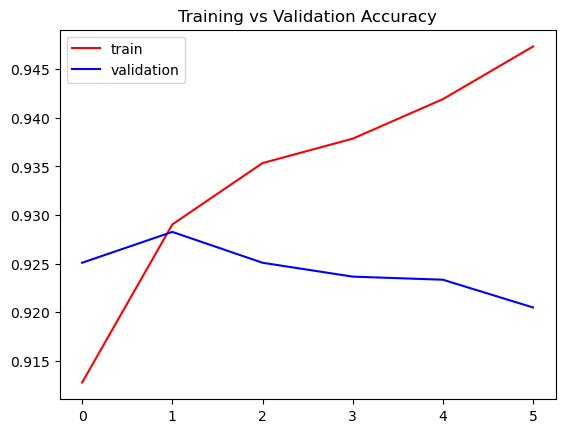

In [25]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [27]:
vgg19_model.save_weights('saves/64_vgg19_64_64_weights')